In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Define dataset paths
train_dir = r"C:\Users\DELL\Desktop\D4\train"
valid_dir = r"C:\Users\DELL\Desktop\D4\valid"
test_dir = r"C:\Users\DELL\Desktop\D4\test"

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [3]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)

# Load datasets
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Number of classes
NUM_CLASSES = len(train_gen.class_indices)

Found 1879 images belonging to 3 classes.
Found 198 images belonging to 3 classes.


In [4]:
# Load pre-trained VGG19 (excluding top layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)  # Multi-class classification

# Create model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 68s 1us/step


In [5]:
EPOCHS = 50

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS
)


C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 375s 6s/step - accuracy: 0.6377 - loss: 0.9082 - val_accuracy: 0.7121 - val_loss: 0.7730
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 374s 6s/step - accuracy: 0.8024 - loss: 0.5133 - val_accuracy: 0.7576 - val_loss: 0.8171
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 374s 6s/step - accuracy: 0.8211 - loss: 0.4859 - val_accuracy: 0.7727 - val_loss: 0.5518
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 374s 6s/step - accuracy: 0.8541 - loss: 0.4122 - val_accuracy: 0.7626 - val_loss: 0.6436
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 485s 8s/step - accuracy: 0.8623 - loss: 0.3931 - val_accuracy: 0.7727 - val_loss: 0.5386
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 572s 10s/step - accuracy: 0.8576 - loss: 0.3584 - val_accuracy: 0.7626 - val_loss: 0.5564
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 573s 10s/step - accuracy: 0.8618 - loss: 0.3498 - val_accuracy: 0.7980 - val_loss: 0.4950
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3523s 61s/step - accuracy: 0.8606 - loss: 0.3500 - val_accuracy: 0.7778

In [7]:
# Train for 10 more epochs
history2 = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,  # Add 10 more epochs
    initial_epoch=50  # Resume from epoch 50
)


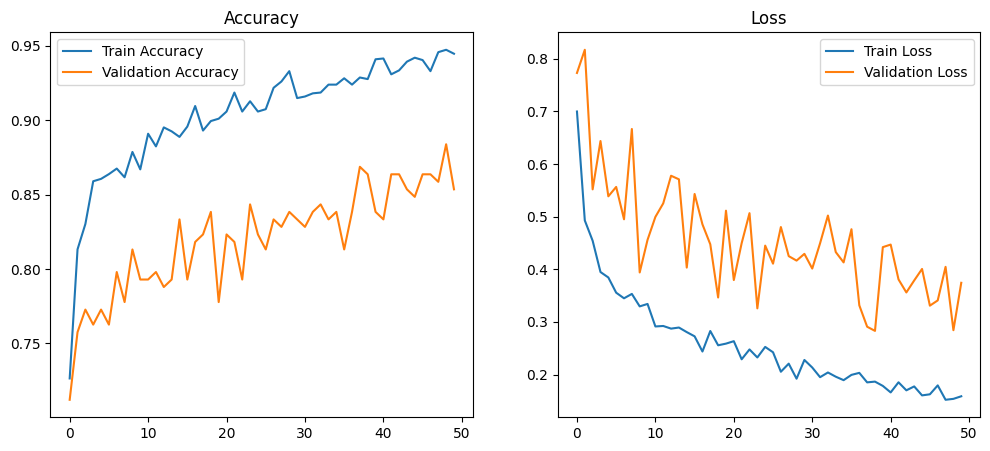

7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step
Confusion Matrix:
 [[101  29  10]
 [ 15   5   1]
 [ 23  11   3]]

Classification Report:
               precision    recall  f1-score   support

  Loose_Smut       0.73      0.72      0.72       140
mildew_valid       0.11      0.24      0.15        21
    septoria       0.21      0.08      0.12        37

    accuracy                           0.55       198
   macro avg       0.35      0.35      0.33       198
weighted avg       0.57      0.55      0.55       198



In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Plot Accuracy & Loss
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_metrics(history)

# Compute Confusion Matrix
def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=generator.class_indices.keys()))

evaluate_model(model, valid_gen)


In [9]:
print("after 50 epochs !!!")

after 50 epochs !!!


In [17]:
print("OK")

OK
